## Reading the data sets and preprocessing data

In [1]:
import pandas as pd

train = pd.read_csv('train.csv')
holdout = pd.read_csv('test.csv')
print(train.head())

   PassengerId  Survived  Pclass  \
0            1         0       3   
1            2         1       1   
2            3         1       3   
3            4         1       1   
4            5         0       3   

                                                Name     Sex   Age  SibSp  \
0                            Braund, Mr. Owen Harris    male  22.0      1   
1  Cumings, Mrs. John Bradley (Florence Briggs Th...  female  38.0      1   
2                             Heikkinen, Miss. Laina  female  26.0      0   
3       Futrelle, Mrs. Jacques Heath (Lily May Peel)  female  35.0      1   
4                           Allen, Mr. William Henry    male  35.0      0   

   Parch            Ticket     Fare Cabin Embarked  
0      0         A/5 21171   7.2500   NaN        S  
1      0          PC 17599  71.2833   C85        C  
2      0  STON/O2. 3101282   7.9250   NaN        S  
3      0            113803  53.1000  C123        S  
4      0            373450   8.0500   NaN        S  


In [2]:
# %load functions.py
def process_missing(df):
    """Handle various missing values from the data set

    Usage
    ------

    train = process_missing(train)
    """
    df["Fare"] = df["Fare"].fillna(train["Fare"].mean())
    df["Embarked"] = df["Embarked"].fillna("S")
    return df

def process_age(df):
    """Process the Age column into pre-defined 'bins' 

    Usage
    ------

    train = process_age(train)
    """
    df["Age"] = df["Age"].fillna(-0.5)
    cut_points = [-1,0,5,12,18,35,60,100]
    label_names = ["Missing","Infant","Child","Teenager","Young Adult","Adult","Senior"]
    df["Age_categories"] = pd.cut(df["Age"],cut_points,labels=label_names)
    return df

def process_fare(df):
    """Process the Fare column into pre-defined 'bins' 

    Usage
    ------

    train = process_fare(train)
    """
    cut_points = [-1,12,50,100,1000]
    label_names = ["0-12","12-50","50-100","100+"]
    df["Fare_categories"] = pd.cut(df["Fare"],cut_points,labels=label_names)
    return df

def process_cabin(df):
    """Extract the first letter in the Cabin column 

    Usage
    ------

    train process_cabin(train)
    """
    df["Cabin_type"] = df["Cabin"].str[0]
    df["Cabin_type"] = df["Cabin_type"].fillna("Unknown")
    df = df.drop('Cabin',axis=1)
    return df

def process_titles(df):
    """Extract and categorize the title from the name column 

    Usage
    ------

    train = process_titles(train)
    """
    titles = {
        "Mr" :         "Mr",
        "Mme":         "Mrs",
        "Ms":          "Mrs",
        "Mrs" :        "Mrs",
        "Master" :     "Master",
        "Mlle":        "Miss",
        "Miss" :       "Miss",
        "Capt":        "Officer",
        "Col":         "Officer",
        "Major":       "Officer",
        "Dr":          "Officer",
        "Rev":         "Officer",
        "Jonkheer":    "Royalty",
        "Don":         "Royalty",
        "Sir" :        "Royalty",
        "Countess":    "Royalty",
        "Dona":        "Royalty",
        "Lady" :       "Royalty"
    }
    extracted_titles = df["Name"].str.extract(' ([A-Za-z]+)\.',expand=False)
    df["Title"] = extracted_titles.map(titles)
    return df

def create_dummies(df,column_name):
    """Create Dummy Columns (One Hot Encoding) from a single Column

    Usage
    ------

    train = create_dummies(train,"Age")
    """
    dummies = pd.get_dummies(df[column_name],prefix=column_name)
    df = pd.concat([df,dummies],axis=1)
    return df

In [3]:
def process_data(df):
    new_df = process_missing(df)
    new_df = process_age(new_df)
    new_df = process_fare(new_df)
    new_df = process_titles(new_df)
    new_df = process_cabin(new_df)
    
    for column in ['Age_categories','Fare_categories', 'Title',
                  'Cabin_type', 'Sex']:
        new_df = create_dummies(new_df, column)
   
    return new_df

train = process_data(train)
holdout = process_data(holdout)   
print(train.head())

   PassengerId  Survived  Pclass  \
0            1         0       3   
1            2         1       1   
2            3         1       3   
3            4         1       1   
4            5         0       3   

                                                Name     Sex   Age  SibSp  \
0                            Braund, Mr. Owen Harris    male  22.0      1   
1  Cumings, Mrs. John Bradley (Florence Briggs Th...  female  38.0      1   
2                             Heikkinen, Miss. Laina  female  26.0      0   
3       Futrelle, Mrs. Jacques Heath (Lily May Peel)  female  35.0      1   
4                           Allen, Mr. William Henry    male  35.0      0   

   Parch            Ticket     Fare    ...    Cabin_type_B Cabin_type_C  \
0      0         A/5 21171   7.2500    ...               0            0   
1      0          PC 17599  71.2833    ...               0            1   
2      0  STON/O2. 3101282   7.9250    ...               0            0   
3      0            

## Exploring data and engineering new features

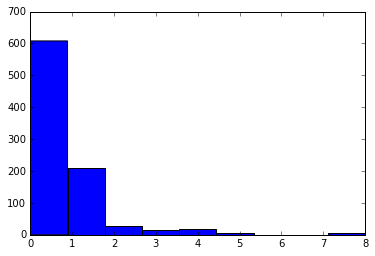

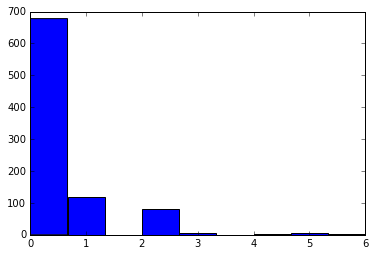

In [4]:
# explore SibSp and Parch columns
train['SibSp'].describe()
train['Parch'].describe()

import matplotlib.pyplot as plt
%matplotlib inline

plt.hist(train['SibSp'], bins=9)
plt.show()

plt.hist(train['Parch'], bins=9)
plt.show()

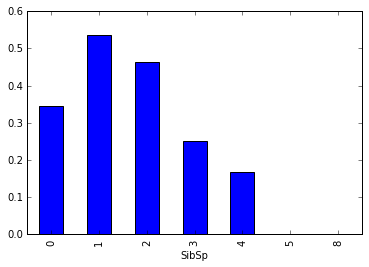

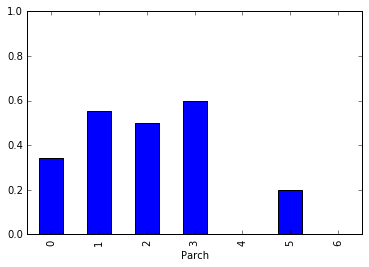

In [5]:
sibsp_pivot = train.pivot_table(index='SibSp', values='Survived')
sibsp_pivot.plot.bar()
plt.show()

parch_pivot = train.pivot_table(index='Parch', values='Survived')
parch_pivot.plot.bar(ylim=(0,1))
plt.show()

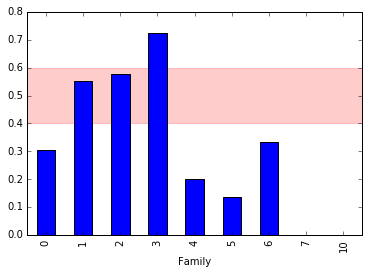

In [6]:
train['Family'] = train[["SibSp","Parch"]].sum(axis=1)
family_pivot = train.pivot_table(index='Family', values='Survived')
plt.axhspan(.4, .6, alpha=0.2, color='red')
family_pivot.plot.bar()
plt.show()

Both "SibSp" (siblings and spouses) and "Parch" (parents and children) columns appear to have an inversed-U relationship with survival. When the two columns are added together to create a new feature indicating total family members, the relationship is even more clear: Passengers with 1-3 family members on board were more likely to survive than those with no family members or more than 3 family members. Therefore, we can create a new feature with three levels: solo, small family, and large family.

In [8]:
def process_family(df):
    df['Family'] = df[["SibSp","Parch"]].sum(axis=1) 
    df['FamilySize'] = 'solo'
    df.loc[((df['Family']>=1) & (df['Family']<=3)), 'FamilySize'] = 'small'
    df.loc[(df['Family']>3), 'FamilySize'] = 'large'
    df = df.drop("Family",axis=1)
    
    # create dummy variables for FamilySize 
    df = create_dummies(df, 'FamilySize')
    return df

train = process_family(train)
holdout = process_family(holdout)

## Selecting the best features for prediction

In [10]:
from sklearn.feature_selection import RFECV
from sklearn.ensemble import RandomForestClassifier
import numpy as np

def select_features(df):
    # remove non-numeric columns or columns containing null values
    df_numerics = df.select_dtypes(include=[np.number])
    df_numerics_dropna = df_numerics.dropna(axis=1)
    
    all_X = df_numerics_dropna.drop(['PassengerId','Survived'], axis=1)
    all_y = df_numerics_dropna['Survived']
    
    # feature selection with random forest
    rf = RandomForestClassifier(random_state=1)
    selector = RFECV(rf, cv=10)
    selector.fit(all_X, all_y)
    optimized_columns = all_X.columns[selector.support_]
    
    print(optimized_columns)
    return optimized_columns
    
best_predictors = select_features(train)

Index(['Pclass', 'Age', 'SibSp', 'Fare', 'Title_Mr', 'Cabin_type_Unknown',
       'Sex_female', 'Sex_male', 'FamilySize_small'],
      dtype='object')


## Selecting and tuning different models

In [13]:
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression

def select_model(df, features):
    all_X = df[features]
    all_y = df['Survived']
    
    # a list of dictionaries, each containing an algorithm name,
    # its estimator, and a dictionary of hyperparameters
    models = [{'name': 'Logistic regression',
              'estimator': LogisticRegression(),
              'hyperparameters': 
                  {"solver": ["newton-cg", "lbfgs", "liblinear"]}
              },
             {'name': 'K nearest neighbors',
             'estimator': KNeighborsClassifier(),
             'hyperparameters':
                 {"n_neighbors": range(1,20,2),
                 "weights": ["distance", "uniform"],
                 "algorithm": ["ball_tree", "kd_tree", "brute"],
                 "p": [1,2]}
             },
             {'name': 'Random forest',
             'estimator': RandomForestClassifier(),
             'hyperparameters':
                 {"n_estimators": [4, 6, 9],
                 "criterion": ["entropy", "gini"],
                 "max_depth": [2, 5, 10],
                 "max_features": ["log2", "sqrt"],
                 "min_samples_leaf": [1, 5, 8],
                 "min_samples_split": [2, 3, 5]}
             }]
    
    for model in models:
        print(model['name'])
        method = model['estimator']
        grid = GridSearchCV(method, model['hyperparameters'])
        grid.fit(all_X, all_y)
        model['best parameters'] = grid.best_params_
        model['best score'] = grid.best_score_
        model['best estimator'] = grid.best_estimator_
        print(model['best parameters'])
        print(model['best score'])
        
    return models

model_selection = select_model(train, best_predictors)

Logistic regression
{'solver': 'newton-cg'}
0.806958473625
K nearest neighbors
{'p': 1, 'n_neighbors': 15, 'algorithm': 'kd_tree', 'weights': 'distance'}
0.769921436588
Random forest
{'max_features': 'log2', 'n_estimators': 9, 'max_depth': 10, 'min_samples_split': 5, 'criterion': 'gini', 'min_samples_leaf': 8}
0.837261503928


## Making a submission to Kaggle

In [14]:
# function to create a submission data frame and save it as .csv file
def save_submission_file(model, columns, file_name="submission.csv"):
    predictions = model.predict(holdout[columns])
    submission_df = {'PassengerId': holdout['PassengerId'],
                    'Survived': predictions}
    submission = pd.DataFrame(submission_df)
    submission.to_csv(file_name, index=False)

In [15]:
# make predictions with the best random forest model selected above
rf = model_selection[2]['best estimator']
save_submission_file(rf, best_predictors)